In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from functools import partial
import thermal_grid as tg

## Intro: How is energy distributed among particles in a thermal system?

### A "straightforward" answer:

Energy in a system (gas, solid, whatever) is distributed according to the *Boltzmann distribution*.

$ P(E) \propto e^{-E/k_BT} $

You can find easily find this [on Wikipedia](https://en.wikipedia.org/wiki/Boltzmann_distribution)!

A particle is most likely to have zero energy, and less likely to have some amount of energy the higher you go.

$k_B$ is the Boltzmann constant, $1.38 \times 10^{-23}$ Joules/Kelvin.

$k_BT$, the Boltzmann constant times the temperature, is the amount of energy that a particle is $e^{-1}\approx0.37$ times as likely to have as having zero energy.

Some examples of this distribution:

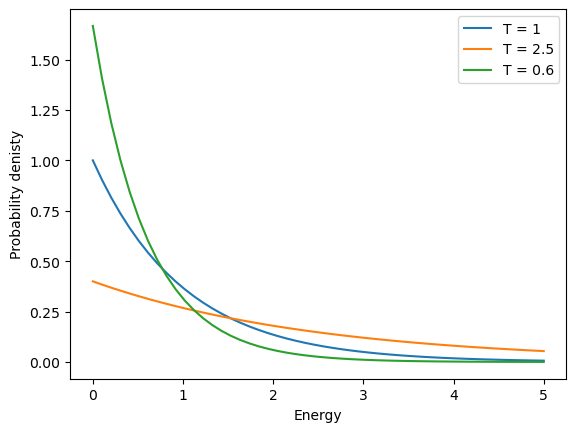

In [2]:
E = np.linspace(0, 5)

T1 = 1
T2 = 2.5
T3 = 0.6

P1 = np.exp(-E/T1) / T1
P2 = np.exp(-E/T2) / T2
P3 = np.exp(-E/T3) / T3

(fig, ax) = plt.subplots()
ax.plot(E, P1, label='T = 1')
ax.plot(E, P2, label='T = 2.5')
ax.plot(E, P3, label='T = 0.6')
ax.set_xlabel('Energy')
ax.set_ylabel('Probability denisty')
ax.legend()
plt.show()

Okay, sure, but...**why is it distributed like that??**

Demo time!

In [3]:
%matplotlib ipympl

In [4]:
def static_viz(grid, max_energy=None, max_frequency=None):
    """
    Creates a visualization of a grid and a histogram of site energies
    Returns objects which are necessary to feed into `update_animation()`
    """
    # Set up plots
    (fig, axes) = plt.subplots(1, 3, figsize=(13, 5), gridspec_kw={'width_ratios': [0.06, 1, 1]})
    ax_cbar = axes[0]
    ax1 = axes[1]
    ax2 = axes[2]

    # Grid visualization
    image = ax1.imshow(grid.state.transpose(), cmap='inferno', vmin=0, vmax=max_energy)
    ax1.set_xticks(np.arange(-0.5, grid.x, 1))
    ax1.set_yticks(np.arange(-0.5, grid.y, 1))
    ax1.grid()
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.tick_params(bottom=False, left=False)

    # Grid viz colorbar
    if max_energy:
        cmap = mpl.cm.inferno
        bounds = range(max_energy+2)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax_cbar)
    else:
        fig.colorbar(image, cax=ax_cbar)

    # Histogram visualization
    if max_energy:
        bins = np.arange(-0.5, max_energy+1)
    else:
        bins = np.arange(-0.5, np.max(grid.state)+1)
    (_, _, bar_container) = ax2.hist(grid.state.flatten(), bins=bins, edgecolor='black')
    if max_energy:
        ax2.set_xlim(-0.5, max_energy+0.5)
        ax2.xaxis.set_major_locator(mpl.ticker.FixedLocator(range(max_energy+1)))
    if max_frequency:
        ax2.set_ylim(0, max_frequency)
    ax2.tick_params(bottom=False)
    ax2.set_xlabel('Number of energy units in a site')
    ax2.set_ylabel('Total sites')

    return fig, axes, image, bins, bar_container

In [5]:
def update_animation(grid, axes, image, bins, bar_container, i, exchanges_per_frame=1, skip_invalid_exchanges=False):
    """
    Function for animating 
    """
    # Exhange energy
    for j in range(exchanges_per_frame):
        grid.exchange_rand_nn(skip_invalid_exchanges)

    # Update grid viz
    image.set_data(grid.state.transpose())

    # Update histogram viz
    (n, _) = np.histogram(grid.state.flatten(), bins)
    for (count, rect) in zip(n, bar_container.patches):
        rect.set_height(count)
    axes[1].set_title(f'Number of exchanges: {exchanges_per_frame*(i+1)}')


# 4x4 grid

Visualize it

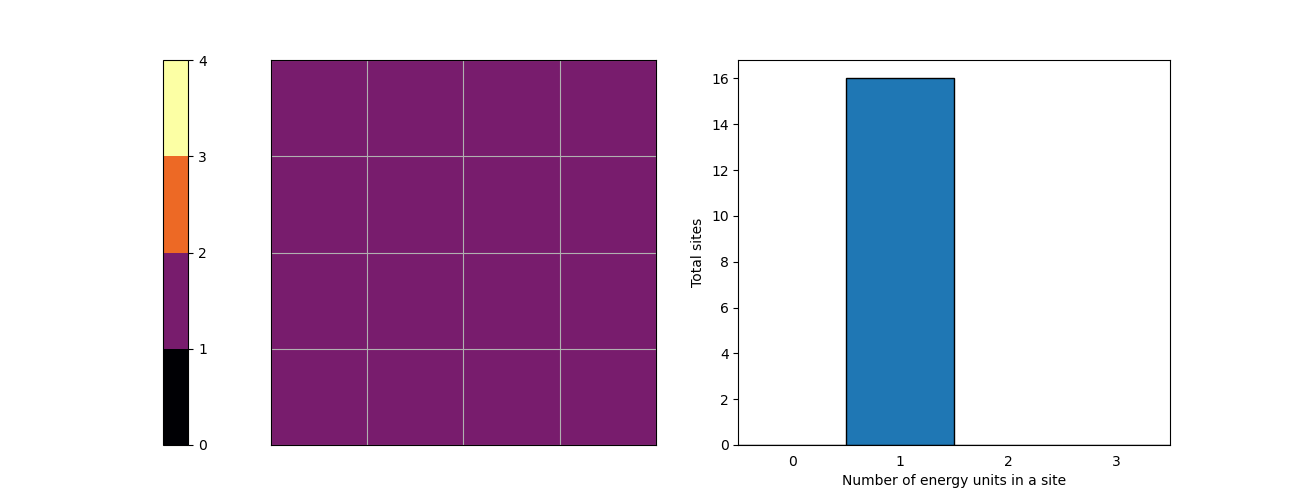

In [6]:
grid = tg.thermal_grid_uniform(4, 4, 1)
static_viz(grid, 3)
plt.show()

Exchange one unit of energy

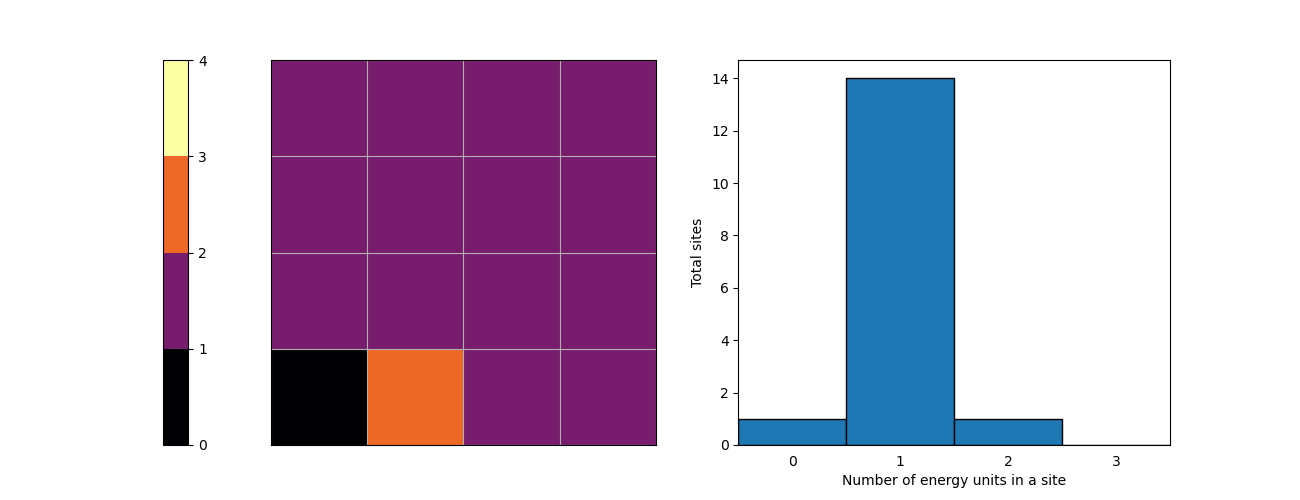

In [7]:
grid.exchange_rand_nn()
static_viz(grid, 3)
plt.show()

Animate exchanging 50 units of energy, one at a time

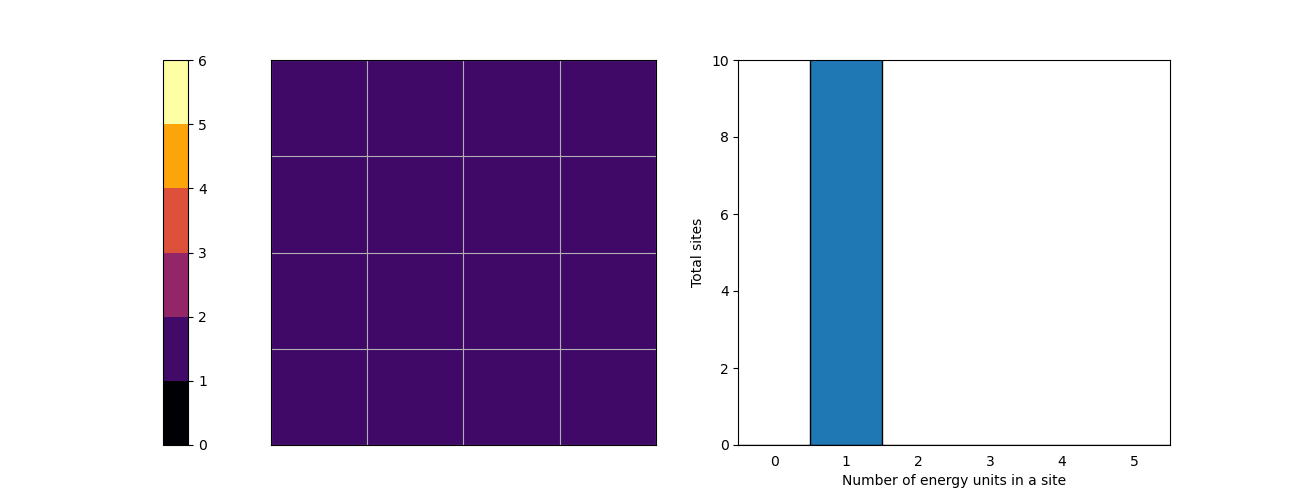

In [8]:
grid = tg.thermal_grid_uniform(4, 4, 1)
(fig, *other_stuff) = static_viz(grid, 5, 10)

animation = FuncAnimation(fig, partial(update_animation, grid, *other_stuff),
                          frames=50, interval=500, repeat=False)
plt.show()

# 16 x 16 grid

Visualize

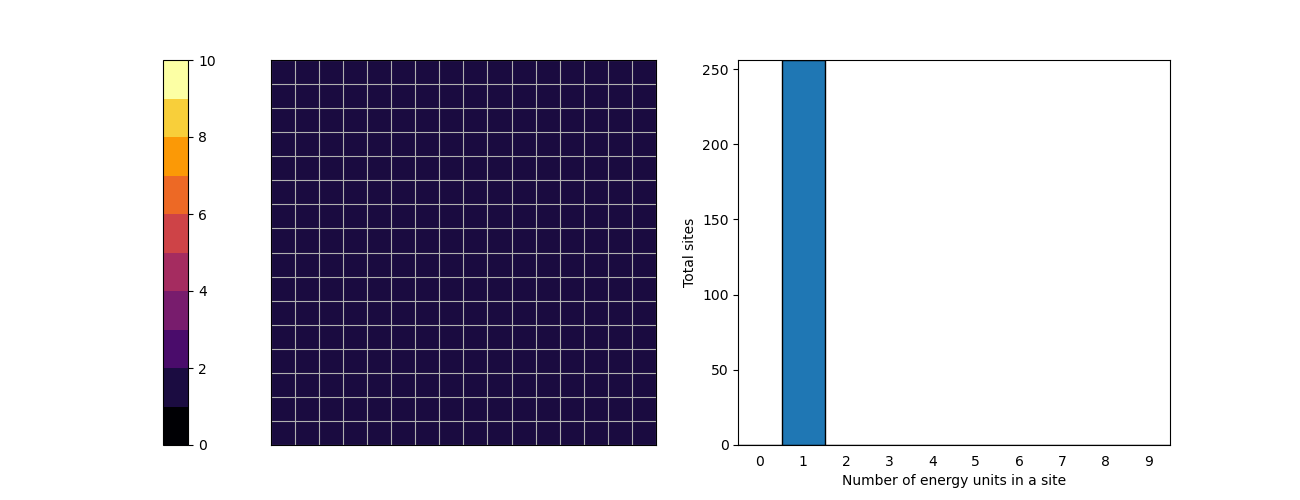

In [9]:
grid = tg.thermal_grid_uniform(16, 16, 1)
static_viz(grid, 9, 256)
plt.show()

Animate 1000 exchanges

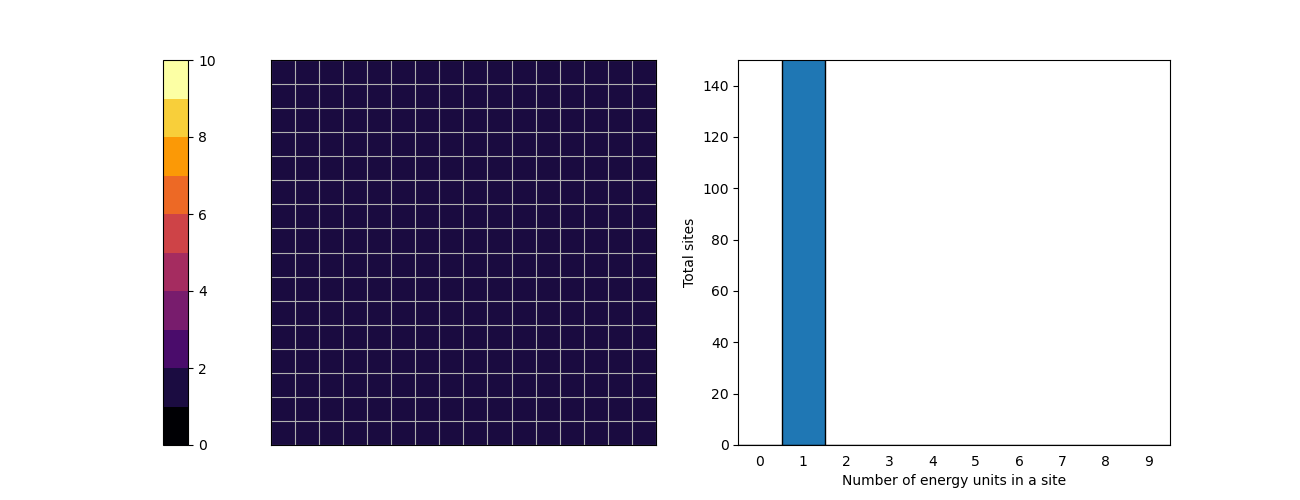

In [10]:
grid = tg.thermal_grid_uniform(16, 16, 1)
(fig, *other_stuff) = static_viz(grid, 9, 150)

animation = FuncAnimation(fig, partial(update_animation, grid, *other_stuff),
                          frames=1000, interval=10, repeat=False)
plt.show()

# Different initial distribution

What if instead of the energy initially distributed evenly among all sites, it's all concentrated in a single one?

Visualize

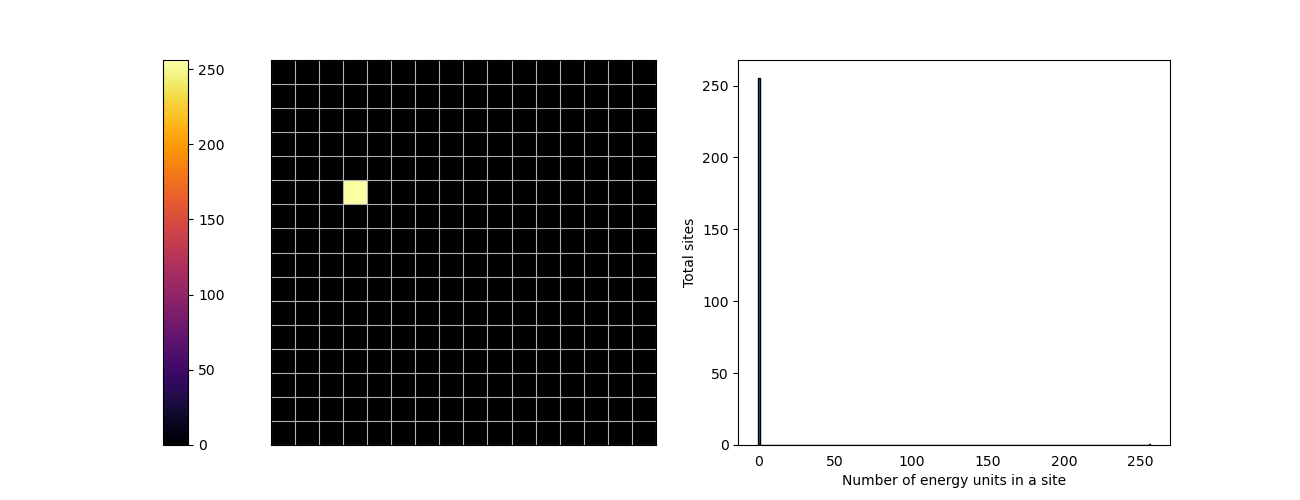

In [11]:
grid = tg.thermal_grid_allinone(16, 16, (3, 5), 256)
static_viz(grid)
plt.show()

Animate 100,000 exchanges

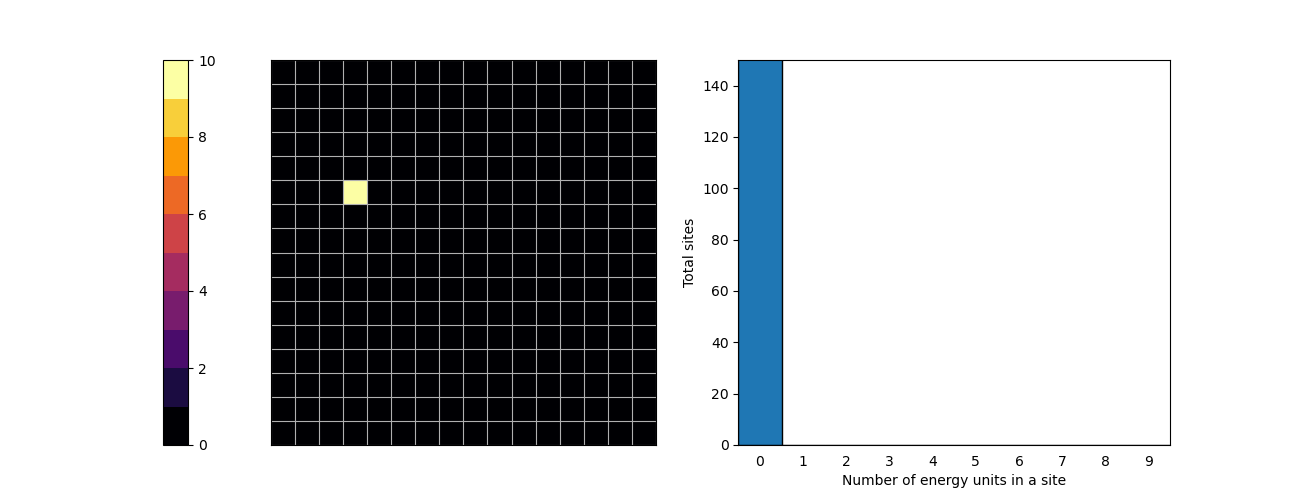

In [12]:
grid = tg.thermal_grid_allinone(16, 16, (3, 5), 256)
(fig, *other_stuff) = static_viz(grid, 9, 150)

animation = FuncAnimation(fig, partial(update_animation, grid, *other_stuff, exchanges_per_frame=100),
                          frames=1000, interval=5, repeat=False)
plt.show()

# Lower temperature

What happens if there's less total energy in the system to begin with?

Visualize: Only 32 units of energy, initially concentrated in a 4x4 subgrid

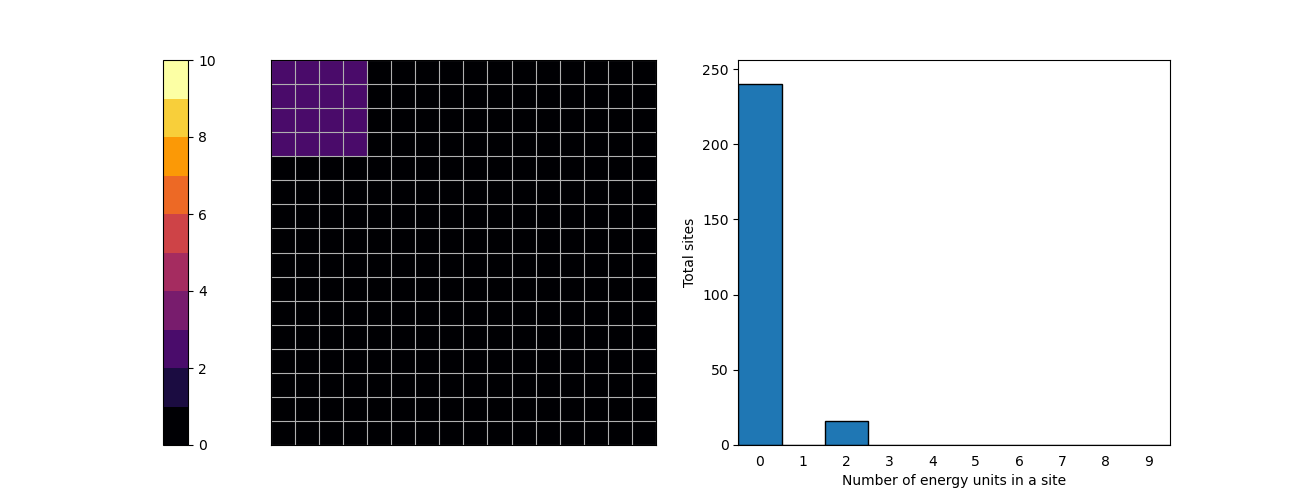

In [13]:
grid = tg.thermal_grid_uniform_subgrid(16, 16, 4, 4, 2)
static_viz(grid, 9, 256)
plt.show()

Animate 5000 exchanges

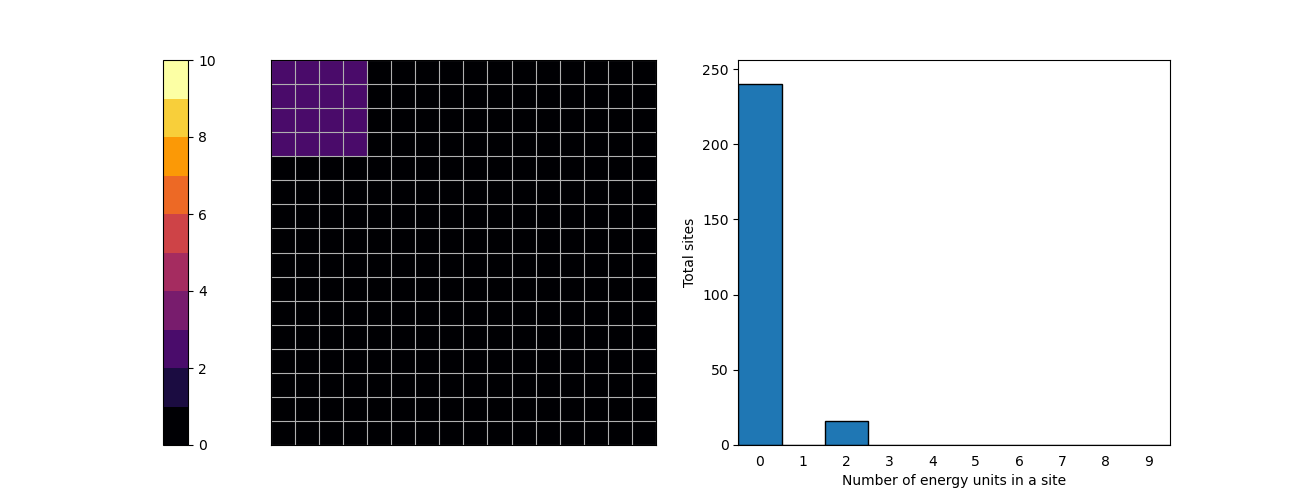

In [14]:
grid = tg.thermal_grid_uniform_subgrid(16, 16, 4, 4, 2)
(fig, *other_stuff) = static_viz(grid, 9, 256)

animation = FuncAnimation(fig, partial(update_animation, grid, *other_stuff, exchanges_per_frame=5),
                          frames=1000, interval=2, repeat=False)
plt.show()

# Higher temperature

Finally, what happens if there's more total energy in the system?

Visualize 5 units of energy per site, distributed uniformly

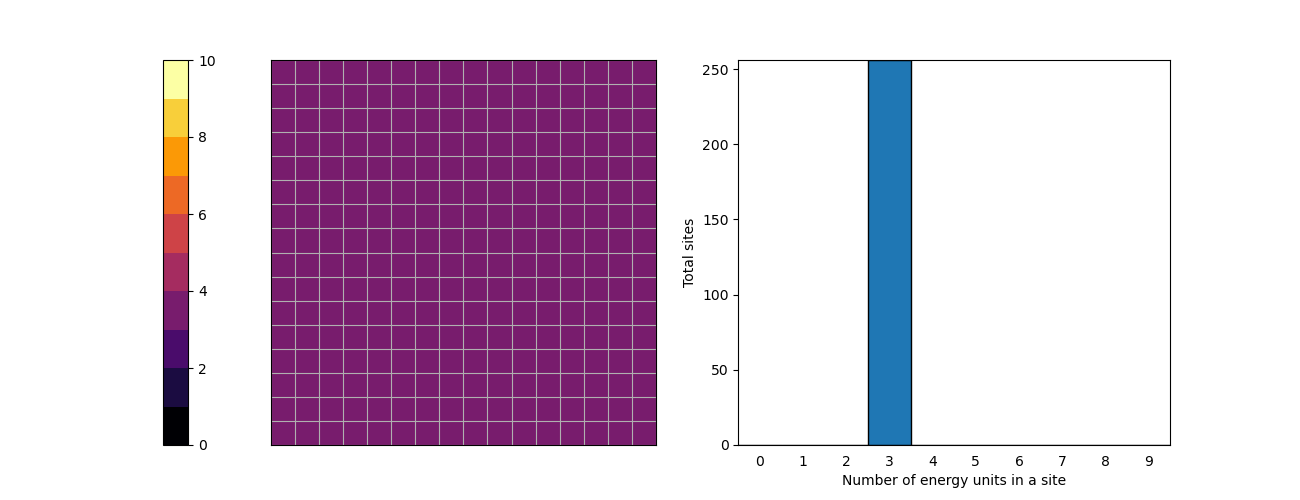

In [15]:
grid = tg.thermal_grid_uniform(16, 16, 3)
static_viz(grid, 9, 256)
plt.show()

Animate 10,000 exchanges

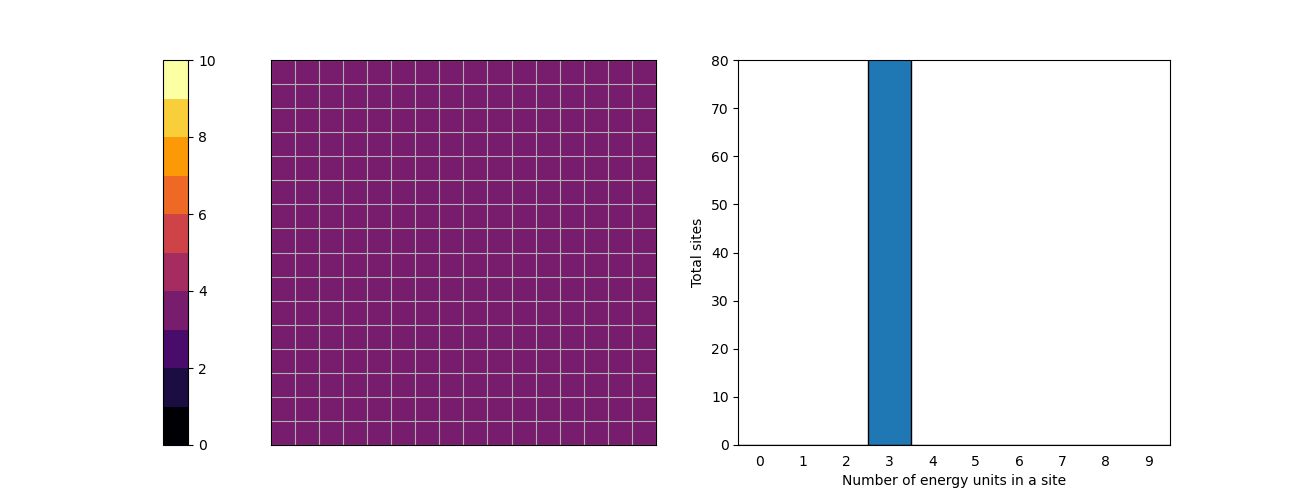

In [17]:
grid = tg.thermal_grid_uniform(16, 16, 3)
(fig, *other_stuff) = static_viz(grid, 9, 80)

animation = FuncAnimation(fig, partial(update_animation, grid, *other_stuff, exchanges_per_frame=10, skip_invalid_exchanges=True),
                          frames=1000, interval=2, repeat=False)
plt.show()

# Recap

- What is temperature?

  - It's a measure of the average kinetic energy per particle in a system!

 <br>

- But what about the whole distribution of the energy among the particles?

  - It always follows a Boltzmann distribution!

 <br>

- But why that one?

  - It is just the most combinatorically probable way that things (energy) can be randomly distributed!